## Markov Chain Monte Carlo (MCMC)

MCMC is a class of algorithms used for sampling from complex probability distributions or for evaluating complex integrals. For example in Bayesian inference, MCMC is used to estimate the posterior distribution.

In this instance we are using the Metropolis-Hastings MCMC (MH-MCMC). This is used as we have a function proportional to a probability density. The MH-MCMC proposes new states based on a proposal distribution, The starting point and arbitrary probability density are chosen where in this case we use an anisotropic gaussian pdf to chose the next sample (MH uses symmetric probability distributions). The sample is proposed given the previous sample and the proposed sample is only selected if it meets the acceptance probability, $\alpha$. This is calculated through
$$\alpha(x, x') = min(1, \frac{\rho(x')q(x'|x)}{\rho(x)q(x|x')})$$ 
(for computational implementation use the log form of this equation to reduce floating point errors).

For the gaussian random walk used here, the q's cancel due to symmetry so only the terms regarding $\rho$ are left.

This acceptance probability is compared with a number drawn from a uniform distribution $z \sim \text{Unif}([0, 1])$, where if $z \leq \alpha$ then the candidate is accepted. If not the candidate is rejected and another potential candidate is drawn using the last accepted candidate.

The technique will be shown on two different probability distributions:
For dimension $n=1$: 
$$
\rho(x) \propto \exp(-(x^2 - 1)^2)
$$
For dimension $n = 2$, the density used here is:
$$
\rho((x_1, x_2)) \propto \exp(-((x_1 - 1)^2 + 50(x_2 - x_1^2)^2))
$$

MCMC has the problem of autocorrelated samples - this means the effective sample size is alot smaller than the actual. Initial samples may follow a different distribution than final ones so there is often a built in burn-in time where all samples are rejected.

We are also keeping track of the average acceptance probability and average acceptance rate. This allows us too see how the algorithm is evolving whilst allowing the step size to be tuned to achieve the desired average acceptance rate of 23% (derived from some maths).

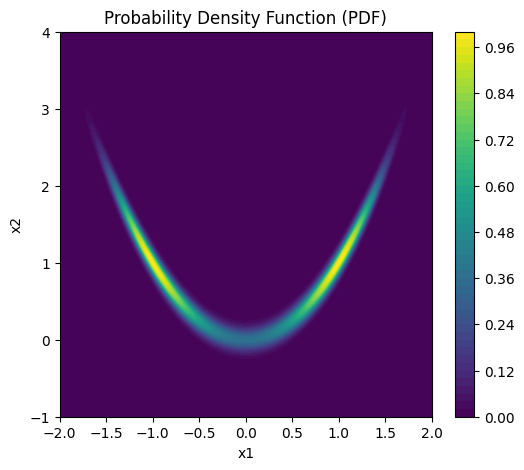

In [2]:
#First I have coded the 2D probability distribution to allow visualisation of the problem.

import numpy as np
import matplotlib.pyplot as plt

#density sampled from
def rho_2d(x):
    x1, x2 = x
    return np.exp(-((x1**2 - 1)**2 + 50*(x2-x1**2)**2))


# visualising density
x1_vals = np.linspace(-2, 2, 400)
x2_vals = np.linspace(-1, 4, 400)

X1, X2 = np.meshgrid(x1_vals, x2_vals)

Z = rho_2d([X1, X2])

# Plotting the PDF using a filled contour plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
contour = ax.contourf(X1, X2, Z, levels=50, cmap='viridis')
fig.colorbar(contour)

ax.set_title('Probability Density Function (PDF)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.show()


Can see this is a 'banana' distribution, chosen as is hard to sample the etremities.

In [6]:
#we can then implement the GRW_MH_MCMC to sample from the distribution

N_samples = 100000
step_size = 0.5 #small change in step size makes large difference
#is neccessary to investigate the optimal step size that provides the best coverage of the probability space
#or too use an adaptive step size

#for 2D rho, used SPSD covariance matrix
x_initial = np.array([1, 1])
cov = np.array([[2, 0],
                [0, 1]])
L = np.linalg.cholesky(cov)

#we shall prelog the pdf to avoid computational errors from computing with small values
def log_rho_2d(x):
    x1, x2 = x
    return -((x1 - 1)**2 + 50*(x2 - x1**2)**2)

def rho_1d(x):
    return np.exp(-(x**2 - 1)**2)

def log_rho_1d(x):
    return -(x**2 - 1)**2


def metropolis_hastings(x0, rho, L, N, step_size, adapt_step_size=False):
    x = [x0]
    log_acceptance_probability = []
    acceptance_counter = 0
    for i in range(1, N):
        x_candidate = x[i-1] + step_size**2 * L@np.random.normal(size = len(L))
        log_acceptance_ratio = min(0, rho(x_candidate) - rho(x[i-1])) #log version used again to avoid computational problems
        log_acceptance_probability.append(log_acceptance_ratio)
        log_z = np.log(np.random.uniform())#compared with logged value
        #if meets acceptance allow the proposed move
        if log_z <= log_acceptance_ratio:
            x.append(x_candidate)
            acceptance_counter += 1 #easy to calculate probability of acceptance
        #if not then stay where is
        else:
            x.append(x[i-1])
        
        #modifying step size at every 100th iteration
        if adapt_step_size:
            if i % 100 == 0:
                av_acc_prob = (1/i)*np.sum(np.exp(log_acceptance_probability)) #calculating average of the acceptance probabilites so far
                if av_acc_prob > 0.27:
                    step_size = step_size *2
                elif av_acc_prob < 0.19:
                    step_size = step_size /2
    return x, log_acceptance_probability, acceptance_counter




In [7]:
rho_2d_samples, log_acc_prob, acc_count = metropolis_hastings(x_initial, log_rho_2d, L, N_samples, step_size, adapt_step_size=True)
av_prob = (1/N_samples)*np.sum(np.exp(log_acc_prob))
av_count = (1/N_samples)*acc_count

print(f"Average Acceptance probabilty = {av_prob:.5g}, Average Acceptance rate = {av_count:.5g}")

Average Acceptance probabilty = 0.23028, Average Acceptance rate = 0.22963


We can see that we have achieved the desired acceptance rate of 23% using the adaptive step size.

We can plot the trace plot to investigate the coverage of the probability space.

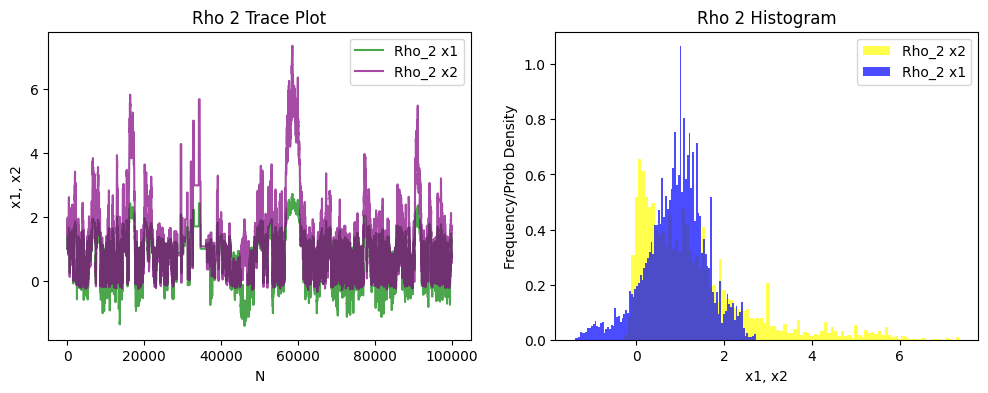

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = ((12, 4)))

ax1.plot(np.array(rho_2d_samples)[:,0], label = 'Rho_2 x1', color = 'green', alpha = 0.7)
ax1.plot(np.array(rho_2d_samples)[:,1], label = 'Rho_2 x2', color = 'purple', alpha = 0.7)
ax1.set_title('Rho 2 Trace Plot')
ax1.set_xlabel('N')
ax1.set_ylabel('x1, x2')
ax2.hist(np.array(rho_2d_samples)[:,1], label = 'Rho_2 x2', color = 'yellow', density = True, bins=100, alpha = 0.7)
ax2.hist(np.array(rho_2d_samples)[:,0], label = 'Rho_2 x1', color = 'blue', density = True, bins = 100, alpha = 0.7)
ax2.set_title('Rho 2 Histogram')
ax2.set_xlabel('x1, x2')
ax2.set_ylabel('Frequency/Prob Density')
ax1.legend()
ax2.legend()
plt.show()

We can see by comparing the trace plot with the previous contour plot that the algorithm has stayed within the positive section of the x1 and has not explored the total probability space (only 0-2, not -2-0). Therefore a stochastic source may need to be introduce to help it explore the entire probability space. Or you could try change the initial conditions. If you use the 1D pdf you can see what the trace plot should look like when covering the entire probability space.

Could try to recreate the contour plot from the histograms.